# Sieci konwolucyjne (splotowe) - CNN

Dziś spróbujemy użyć innej architektury sieci, aby uzyskać lepsze wyniki w rozpoznawaniu mowy. Na początek zajmiemy się siecią konwolucyjną, zwaną też siecią splotową (CNN, *convolutional neural network*), czyli taką, która dokonuje operacji splotu na danych. Sieci konwolucyjne są szczególnie przydatne w rozwiązywaniu problemów związanych z rozpoznawaniem obrazów i systemami wizyjnymi. Są także stosowane w analizie innych sygnałów, również akustycznych - jeśli mamy dwuwymiarową macierz cech (np. spektrogram, macierz współczynników MFCC), możemy potraktować ją jak obraz.

Zanim przejdziemy do opisu parametrów, które należy zdefiniować podczas implementacji CNN oraz definicji pojęć potrzebnych do zrozumienia kodu, zastanówmy się, czemu wprowadzenie warstw konwolucyjnych tak istotnie wpływa na zdolność sieci do poprawnej klasyfikacji obrazów. Dotychczas wszystkie cechy, które podawaliśmy do sieci (oraz innych klasyfikatorów) musiały być w formie wektorów. Jeżeli wyliczaliśmy cechy 2D, np. spektrogram, to przed procesem uczenia zamienialiśmy go na dane jednowymiarowe w taki sposób, że wartości wyliczone dla kolejnych pasm częstotliwości były „doklejane” na końcu pasma poprzedniego. Takie podejście ma dwie zasadnicze wady:

- tracimy informacje dotyczące rozkładu przestrzennego cech,
- dostajemy zazwyczaj bardzo długi wektor danych wejściowych, a w przypadku sieci neuronowych warstwa wejściowa musi mieć tyle neuronów, ile cech będzie do niej podanych. Załóżmy, że chcemy uczyć sieć na spektrogramie o wymiarach np. 50 ramek x 13 pasm - oznacza to 650 neuronów. Zazwyczaj sieć składa się z większej liczby warstw, w których są kolejne neurony, a dla każdego neuronu muszą być wyznaczone wagi - to wszystko sprawia, że otrzymujemy ogromną liczbę parametrów, które muszą być wyznaczone podczas uczenia sieci. Wyznaczenie ich optymalnych wartości będzie w takim razie bardzo trudne, trening potrwa długo, a ryzyko przeuczenia sieci w związku ze zbyt małą liczbą danych będzie duże.

Stosując warstwy konwolucyjne, przystosowane do pracy z danymi 2D, możemy tych problemów uniknąć. Wykonujemy splot danych wejściowych (lub wyjścia jednej z kolejnych warstw sieci) z **filtrem**, którego współczynniki są aktualizowane w procesie uczenia sieci.

## Splot w pytorchu

Splot może jednak dotyczyć nie tylko danych dwuwymiarowych - w PyTorchu można użyć jednej z trzech klas:
    
- [`nn.Conv1d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html#torch.nn.Conv1d) - przeprowadza splot jednowymiarowy, stosowana jest zazwyczaj na sekwencyjnych danych jednowymiarowych (chociaż można go też zastosować na danych 2D), np. do analizy tekstu lub sygnałów audio. Dane wejściowe powinny mieć wymiary `[batch_size, input_channels, signal_length]`.
- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d) - przeprowadza splot dwuwymiarowy, stosowana jest głownie w analizie obrazów. Dane wejściowe powinny mieć wymiary `[batch_size, input_channels, input_height, input_width]`.
- [`nn.Conv3d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv3d.html#torch.nn.Conv3d) - przeprowadza splot trójwymiarowy, stosowana jest głownie w analizie wideo lub danych przestrzennych (np. MRI struktury anatomicznej). Dane wejściowe powinny mieć wymiary `[batch_size, input_channels, input_depth, input_height, input_width]`.

Pracujemy na tych samych danych, co tydzień temu, będziemy więc używać splotu dwuwymiarowego: klasy `nn.Conv2d`.

## Importy i wczytanie danych

In [2]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 7.0 MB/s eta 0:00:00


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from ignite.engine import create_supervised_trainer, create_supervised_evaluator, Events
from ignite.metrics import Loss, Accuracy
from ignite.contrib.handlers import ProgressBar
from ignite.handlers import FastaiLRFinder

/usr/local/lib/python3.11/dist-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
folder = 'drive/MyDrive/PUM/Lab8-9/' #zmodyfikuj ścieżkę odpowiednio do lokalizacji plików
feats = np.load(folder+'melspec_feats.npy')
labels = np.load(folder+'labels.npy')

In [6]:
feats = np.expand_dims(feats, axis=1) #dodanie jednostkowego wymiaru - "kanałów"
feats = feats.astype(np.float32)

X_train, X_val_test, y_train, y_val_test = train_test_split(feats, labels, random_state=42,
                                                            stratify=labels, train_size=0.8)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, random_state=42,
                                                stratify=y_val_test, train_size=0.5)

In [7]:
feats.shape

(10500, 1, 99, 26)

In [8]:
trainset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
valset = TensorDataset(torch.tensor(X_val), torch.tensor(y_val))
testset = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))

train_loader = DataLoader(trainset, batch_size=256)
val_loader = DataLoader(valset, batch_size=256)
test_loader = DataLoader(testset, batch_size=256)

## Definicja sieci

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=10, stride=1, padding=0)
        self.pooling = nn.MaxPool2d(4)
        self.conv1_drop = nn.Dropout2d(p=0.2)
        self.drop1 = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(880, 100)
        self.fc2 = nn.Linear(100, 35)
        self.relu = nn.ReLU()

    def forward(self, x):
#        print(x.shape)
        x = self.conv1(x)
        x = self.relu(self.pooling(x))
#         print(x.shape)
        x = self.conv1_drop(x)
#         print(x.shape)
        x = x.view(-1, 880) #zmiana kształtu danych - działa podobnie do funkcji np.reshape
                            #musimy zmienić kształt danych, ponieważ na wyjściu warstwy konwolucyjnej mamy dane 4D (batch_size x liczba kanałów x liczba_cech x liczba_ramek), a warstwa gęsta przyjmuje dane 2D (batch_size x łączna_liczba_cech)
#         print(x.shape)
        x = self.fc1(x)
#         print(x.shape)
        x = self.drop1(x)
#         print(x.shape)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) # możemy skorzystać z torch.nn.functional zamiast definiować warstwę w konstruktorze

Przyjrzyjmy się temu, co dzieje się w powyższym kodzie.

W funkcji `__init__` inicjalizujemy warstwy: konwolucyjną (`conv1`), dropuot dwuwymiarowy (`conv1_drop`), droput jednowymiarowy (`drop1`) oraz dwie warstwy gęste (`fc1`, `fc2`).

Inicjalizując warstwy splotowe (w naszym przypadku `conv1`) należy zdefiniować trzy hiperparametry:

- in_channels - liczba kanałów wejściowych,
- out_channels - liczba kanałów wyjściowych,
- kernel_size - rozmiar jądra splotu.

Liczba kanałów wejściowych odnosi się do kanałów tensora podawanego do sieci. Jeżeli mamy wyekstrahowane dane zapisane w macierzy o wymiarach:

`liczba_sygnałów` $\times$ `liczba_cech` $\times$ `liczba_ramek`,

to zamieniamy je na tensor, który będzie podawany do sieci i ten tensor ma wymiary:

`liczba_sygnałów` $\times$ `liczba_kanałów` $\times$ `liczba_cech` $\times$ `liczba_ramek`.

W przypadku naszych danych `liczba_kanałów = 1`. Gdybyśmy analizowali dane będące obrazami kolorowymi zapisanymi w RGB, to liczba kanałów wynosiłaby 3.

Liczba kanałów wyjściowych jest liczbą całkowitą określającą liczbę kanałów tensora, który uzyskamy na wyjściu warstwy konwolucyjnej, czyli tzw. mapy cech (*feature map*).

## Parametry splotu

Rozmiar jądra splotu określa, z jakiej części danych wejściowych obliczymy splot. Dodatkowo, operacja splotu w sieci neuronowej może być przeprowadzona w dwóch wariantach, które określamy parametrem ***padding***:

- `padding='same'` - liczony jest splot filtra i obrazu uzupełnionego zerami tak, by na wyjściu uzyskać taki sam rozmiar danych, jak na wejściu. Jest to szczególnie istotne w przypadku głębokich sieci, ponieważ pozwala przeprowadzić więcej operacji bez redukcji wymiarowości.
- `padding='valid'` - inaczej zapisywany jako `padding=0`, oznacza brak *paddingu*, a w wyniku splotu rozmiar danych ulega redukcji.

![caption](https://i.stack.imgur.com/O01D7.png)


Kolejnym parametrem, który definiujemy podczas inicjalizacji warstwy konwolucyjnej jest ***stride*** (krok), który oznacza, o ile próbek przesuwany jest filtr. Domyślnie `stride=1` i dla takiego przypadku przeprowadziliśmy powyższe obliczenia. Jest to również jedyna wartość, dla której *padding* może przyjąć wartość 'same'.

Wartość parametru *stride* ma wpływ na to, jaki rozmiar danych uzyskamy po operacji splotu przy braku *paddingu* - im większy *stride*, tym większa redukcja wymiarowości.

![caption](https://i.stack.imgur.com/XD2O4.png)

Rozmiar danych, jaki uzyskamy w wyniku operacji splotu można policzyć ze wzorów:

$W_{out} = [\frac{W_{in}+2*p-k}{s}]+1$

$H_{out} = [\frac{H_{in}+2*p-k}{s}]+1$

gdzie $W_{in}$ i $H_{in}$ to odpowiednio szerokość i wysokość obrazu wejściowego, $p$ to rozmiar *paddingu*, $k$ to rozmiar jądra splotu, $s$ to wielkość kroku *stride*, a $W_{out}$ i $H_{out}$ to odpowiednio szerokość i wysokość obrazu wyjściowego.

**Uwaga:** *stride* i *padding* mogą być różne dla każdego z wymiarów, wtedy podczas inicjalizacji należy podać wartości dla obu wymiarów jako (wymiar_dla_wysokości, wymiar_dla_szerokości), np. `stride=(1,2)`.

Więcej na temat operacji splotu w sieciach neuronowych oraz obliczania liczby neuronów wyjściowych można przeczytać [w tym przewodniku](https://arxiv.org/pdf/1603.07285), a [w tym tutorialu](https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md) są animacje ilustrujące poszczególne parametry.

## Pooling

W architekturze sieci pojawiły się dwie rzeczy, których nie omawialiśmy na poprzednich zajęciach. Pierwszą z nich jest warstwa `nn.MaxPool2d`, która wykonuje tzw. ***pooling***, czyli redukcję wymiarowości danych - tym samym zmniejsza liczbę parametrów sieci (wag w kolejnych warstwach) i ryzyko przeuczenia sieci. *Pooling* polega na tym, że wartości mapy cech zawarte w oknie o wymiarach określonych przez `kernel_size` zostają przetworzone na pojedynczą wartość. W przypadku stosowanego przez nas *max-poolingu* ta wartość jest wartością największą w oknie. Definiujemy dla niej parametr *stride*, który podobnie jak w warstwie konwolucyjnej określa, jakie przesunięcie okien ma być zastosowane podczas *poolingu* - domyślnie `stride=None`.

Więcej parametrów, które można zdefiniować znajdziesz w [dokumentacji klasy nn.MaxPool2d](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html#torch.nn.MaxPool2d).

![caption](https://miro.medium.com/max/700/0*lMlVQWvEoUyvr-nW.png)

*Pooling* może być też wykonany poprzez wyznaczenie innej wartości niż maksymalna, np. wartości średniej (*average-pooling*) - wtedy należy użyć klasy [nn.AvgPool2d](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html#torch.nn.AvgPool2d).

Poniżej znajdują się wymiary danych zwracanych na wyjściach kolejnych warstw (jeżeli chcesz je odtworzyć, musisz odkomentować wszystkie funkcje `print` w kodzie z definicją klasy). Przeanalizuj je - czy zgadzają się z tym, co uzyskasz wykonując obliczenia zgodnie z opisanymi wyżej zależnościami?

```
torch.Size([256, 1, 99, 26])
torch.Size([256, 10, 22, 4])
torch.Size([256, 10, 22, 4])
torch.Size([256, 880])
torch.Size([256, 100])
torch.Size([256, 100])
```

## Funkcje aktywacji

Ostatnią nową funkcją użytą podczas definicji sieci jest `F.relu`, która służy do wprowadzenia nieliniowości do sieci neuronowej funkcją **ReLU** (*rectified linear unit*).

Wyobraźmy sobie sieć neuronową złożoną z tysiąca warstw gęstych, gdzie każdą kolejną oznaczamy jako $f_n$. Funkcja przejścia przez taką sieć wyglądałaby tak:

y = $f_{1000}(f_{999}(f_{998}(f_{997}(f_{996}(....(x)...) + c $

Jest to tylko złożenie funkcji liniowych, równoważne ze stworzeniem jednej warstwy gęstej. Dlatego należy do sieci wprowadzić nieliniowość, aby możliwa była jej nauka oraz składanie większej liczby warstw.

Zanim omówimy funkcję ReLU, zastanówmy się, jakie są inne funkcje aktywacji i dlaczego użycie ReLU w sieciach gęstych i konwolucyjnych jest lepszym wyborem.

### Sigmoid

Funkcję logistyczną (zwaną po prostu sigmoidem) poznaliśmy przy okazji omawiania regresji logistycznej - jest to funkcja S-kształtna, która przyjmuje wartości z przedziału $(0,1)$ i dana jest wzorem:

$sigmoid(x) = \frac{1}{1+e^{-x}}$

Ważna różnica między sigmoidem i softmaxem: jeżeli funkcją aktywacji warstwy jest softmax, to wartości wszystkich wyjść sumują się do 1. W przypadku sigmoidu tak nie jest - każde pojedyncze wyjście będzie zwracać wartość z przedziału $(0,1)$, ale ich suma może być większa od 1.

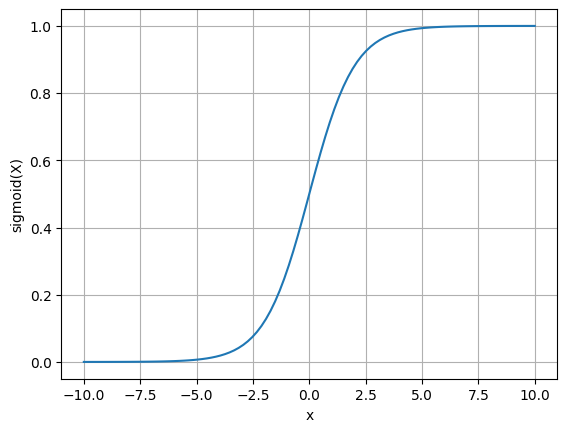

In [10]:
x = np.linspace(start=-10, stop=10, num=100)
y = 1/(1 + np.exp(-np.array(x)))

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("sigmoid(X)")
plt.grid()
plt.show()

### Tangens hiperboliczny

Inną często używaną funkcją (a przy okazji domyślną funkcją aktywacji w warstwach rekurencyjnych) jest tangens hiperboliczny - kształtem przypomina sigmoidę, jednak przyjmuje wartości z przedziału $(-1,1)$ i dany jest wzorem:

$tanh(x) = \frac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$

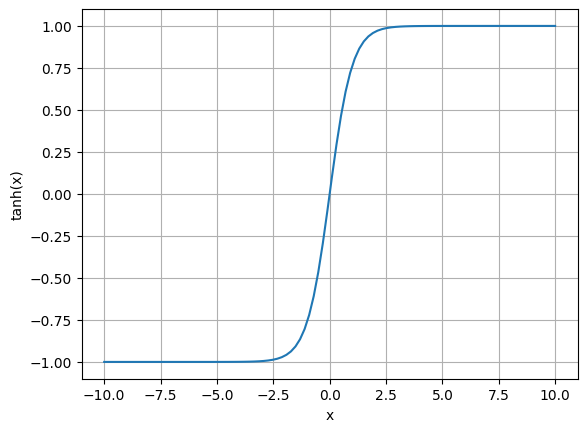

In [11]:
y = np.tanh(x)

plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("tanh(x)")
plt.grid()
plt.show()

### Problem zanikającego gradientu

Funkcja sigmoidalna i tangens hiperboliczny mają jedną zasadniczą wadę - w przypadku głębokich sieci neuronowych ich użycie prowadzi do wystąpienia problemu zanikającego gradientu (*vanishing gradient*).

Jak mówiliśmy na poprzednich zajęciach, wagi w sieci neuronowej zazwyczaj dobierane są na drodze analizy gradientu (metoda SGD). Gdy funkcja aktywacji przyjmuje wartości z przedziału $(0,1)$ lub $(-1,1)$, podanie bardzo dużych lub bardzo małych wartości na wejściu (dążących do $+\infty$ lub $-\infty$) spowoduje uzyskanie pochodnej bliskiej zeru. Gradienty uzyskiwane na kolejnych warstwach sieci są przez siebie mnożone - jeżeli pomnożymy kilka liczb z przedziału $(0,1)$, to uzyskamy bardzo małą liczbę. Sprawia to, że wraz ze wzrostem liczby warstw gradient dąży do zera, co powoduje, że optymalizacja wag będzie wtedy bardzo nieefektywna lub wręcz niemożliwa, a tym samym sieć nie będzie w stanie nauczyć się w stopniu nas zadowalającym.

### ReLU

Jedną z metod radzenia sobie z problemem zanikającego gradientu jest zastosowanie odpowiedniej funkcji aktywacji. Do takich funkcji zalicza się właśnie funkcja ReLU, której użyliśmy podczas definicji sieci. Funkcja ReLU przyjmuje następujące wartości:

- 0, jeżeli na wejście podana zostanie wartość ujemna,
- wartość wejściową, jeżeli zostanie podana wartość dodatnia.

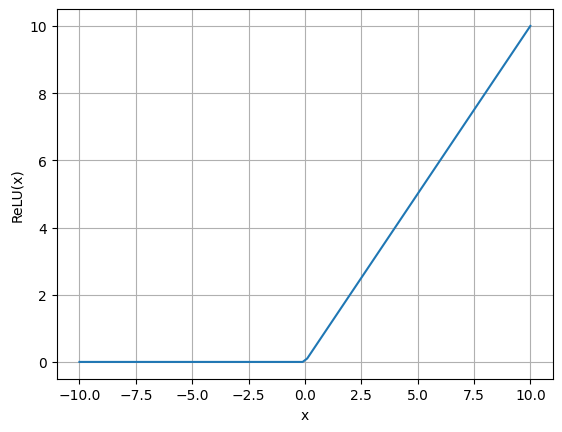

In [12]:
def ReLU(x):
    return max(0.0, x)

y = [ReLU(x) for x in x]
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("ReLU(x)")
plt.grid()
plt.show()

Funkcja ReLU ma kilka istotnych zalet w porównaniu do funkcji sigmoidalnej oraz tangensa hiperbolicznego:

- prostota i szybkość obliczeniowa - nie wymaga użycia funkcji eksponencjalnej;
- może zwrócić wartość 0, a nie jedynie aproksymację zera - dzięki temu możliwe jest uzyskanie na wyjściu macierzy rzadkiej (czyli takiej, w której większość elementów jest równa 0), co przyspiesza proces uczenia;
- zmniejsza problem zanikających gradientów - wartości nie są ograniczane do niewielkich wartości z konkretnego przedziału.

## Trening sieci

Teraz, gdy wyjaśniliśmy już wszystkie nowe pojęcia, możemy przejść do treningu sieci, korzystając z tego samego kodu, którego użyliśmy na poprzednich zajęciach. Od razu użyjemy LRfindera do znalezienia współczynnika uczenia.

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# print(device)
criterion = nn.NLLLoss()
model = ConvNet()
model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1e-8, momentum=0.9)

In [14]:
init_model_state = model.state_dict()
init_opt_state = optimizer.state_dict()

In [15]:
trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
evaluator = create_supervised_evaluator(model, metrics={"acc": Accuracy(), "loss": Loss(nn.NLLLoss())}, device=device)
ProgressBar(persist=True).attach(trainer, output_transform=lambda x: {"batch loss": x})

/usr/local/lib/python3.11/dist-packages/ignite/handlers/tqdm_logger.py:127: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [17]:
lr_finder = FastaiLRFinder()
to_save={'model': model, 'optimizer': optimizer}
with lr_finder.attach(trainer, to_save, diverge_th=1.05, start_lr=1e-8, end_lr=1e-3) as trainer_with_lr_finder:
    #domyślnie start_lr jest taki, jak określony w optimizerze, a end_lr=10
    trainer_with_lr_finder.run(train_loader)

print("Suggested LR", lr_finder.lr_suggestion())

[1/33]   3%|3          [00:00<?]

Suggested LR 0.00035111917342151304


In [18]:
@trainer.on(Events.EPOCH_COMPLETED)
def log_validation_results(trainer):
    evaluator.run(val_loader)
    metrics = evaluator.state.metrics
    print("Validation Results - Epoch: {}  Avg accuracy: {:.2f} Avg loss: {:.2f}"
          .format(trainer.state.epoch, metrics['acc'], metrics['loss']))

lr_finder.apply_suggested_lr(optimizer)
print('Training with suggested lr: ', optimizer.param_groups[0]['lr'])
#trainer.run(trainloader, max_epochs=1000)
trainer.run(train_loader, max_epochs=150)

evaluator.run(test_loader)
print('Test set results:', evaluator.state.metrics)

Training with suggested lr:  0.00035111917342151304


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 1  Avg accuracy: 0.02 Avg loss: 3.62


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 2  Avg accuracy: 0.02 Avg loss: 3.59


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 3  Avg accuracy: 0.02 Avg loss: 3.58


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 4  Avg accuracy: 0.04 Avg loss: 3.56


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 5  Avg accuracy: 0.04 Avg loss: 3.55


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 6  Avg accuracy: 0.06 Avg loss: 3.54


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 7  Avg accuracy: 0.06 Avg loss: 3.50


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 8  Avg accuracy: 0.09 Avg loss: 3.47


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 9  Avg accuracy: 0.11 Avg loss: 3.42


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 10  Avg accuracy: 0.13 Avg loss: 3.36


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 11  Avg accuracy: 0.15 Avg loss: 3.29


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 12  Avg accuracy: 0.16 Avg loss: 3.22


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 13  Avg accuracy: 0.17 Avg loss: 3.15


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 14  Avg accuracy: 0.19 Avg loss: 3.08


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 15  Avg accuracy: 0.20 Avg loss: 3.02


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 16  Avg accuracy: 0.21 Avg loss: 2.96


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 17  Avg accuracy: 0.22 Avg loss: 2.90


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 18  Avg accuracy: 0.23 Avg loss: 2.86


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 19  Avg accuracy: 0.23 Avg loss: 2.82


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 20  Avg accuracy: 0.23 Avg loss: 2.79


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 21  Avg accuracy: 0.24 Avg loss: 2.76


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 22  Avg accuracy: 0.25 Avg loss: 2.74


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 23  Avg accuracy: 0.26 Avg loss: 2.71


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 24  Avg accuracy: 0.25 Avg loss: 2.69


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 25  Avg accuracy: 0.26 Avg loss: 2.67


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 26  Avg accuracy: 0.27 Avg loss: 2.66


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 27  Avg accuracy: 0.28 Avg loss: 2.64


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 28  Avg accuracy: 0.28 Avg loss: 2.63


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 29  Avg accuracy: 0.28 Avg loss: 2.62


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 30  Avg accuracy: 0.29 Avg loss: 2.60


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 31  Avg accuracy: 0.29 Avg loss: 2.59


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 32  Avg accuracy: 0.30 Avg loss: 2.58


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 33  Avg accuracy: 0.31 Avg loss: 2.57


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 34  Avg accuracy: 0.30 Avg loss: 2.56


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 35  Avg accuracy: 0.30 Avg loss: 2.55


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 36  Avg accuracy: 0.30 Avg loss: 2.54


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 37  Avg accuracy: 0.31 Avg loss: 2.53


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 38  Avg accuracy: 0.31 Avg loss: 2.53


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 39  Avg accuracy: 0.31 Avg loss: 2.52


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 40  Avg accuracy: 0.31 Avg loss: 2.51


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 41  Avg accuracy: 0.31 Avg loss: 2.50


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 42  Avg accuracy: 0.31 Avg loss: 2.49


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 43  Avg accuracy: 0.31 Avg loss: 2.49


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 44  Avg accuracy: 0.32 Avg loss: 2.48


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 45  Avg accuracy: 0.32 Avg loss: 2.47


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 46  Avg accuracy: 0.32 Avg loss: 2.46


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 47  Avg accuracy: 0.33 Avg loss: 2.46


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 48  Avg accuracy: 0.32 Avg loss: 2.45


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 49  Avg accuracy: 0.33 Avg loss: 2.44


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 50  Avg accuracy: 0.33 Avg loss: 2.44


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 51  Avg accuracy: 0.34 Avg loss: 2.44


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 52  Avg accuracy: 0.33 Avg loss: 2.42


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 53  Avg accuracy: 0.34 Avg loss: 2.42


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 54  Avg accuracy: 0.35 Avg loss: 2.41


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 55  Avg accuracy: 0.35 Avg loss: 2.41


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 56  Avg accuracy: 0.35 Avg loss: 2.41


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 57  Avg accuracy: 0.35 Avg loss: 2.39


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 58  Avg accuracy: 0.35 Avg loss: 2.39


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 59  Avg accuracy: 0.35 Avg loss: 2.39


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 60  Avg accuracy: 0.35 Avg loss: 2.38


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 61  Avg accuracy: 0.35 Avg loss: 2.38


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 62  Avg accuracy: 0.35 Avg loss: 2.37


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 63  Avg accuracy: 0.36 Avg loss: 2.37


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 64  Avg accuracy: 0.37 Avg loss: 2.36


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 65  Avg accuracy: 0.36 Avg loss: 2.35


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 66  Avg accuracy: 0.36 Avg loss: 2.34


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 67  Avg accuracy: 0.36 Avg loss: 2.34


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 68  Avg accuracy: 0.37 Avg loss: 2.33


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 69  Avg accuracy: 0.37 Avg loss: 2.32


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 70  Avg accuracy: 0.36 Avg loss: 2.32


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 71  Avg accuracy: 0.38 Avg loss: 2.31


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 72  Avg accuracy: 0.37 Avg loss: 2.31


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 73  Avg accuracy: 0.38 Avg loss: 2.30


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 74  Avg accuracy: 0.38 Avg loss: 2.29


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 75  Avg accuracy: 0.38 Avg loss: 2.29


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 76  Avg accuracy: 0.39 Avg loss: 2.29


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 77  Avg accuracy: 0.38 Avg loss: 2.28


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 78  Avg accuracy: 0.38 Avg loss: 2.27


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 79  Avg accuracy: 0.38 Avg loss: 2.27


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 80  Avg accuracy: 0.39 Avg loss: 2.26


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 81  Avg accuracy: 0.39 Avg loss: 2.25


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 82  Avg accuracy: 0.40 Avg loss: 2.24


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 83  Avg accuracy: 0.39 Avg loss: 2.24


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 84  Avg accuracy: 0.39 Avg loss: 2.24


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 85  Avg accuracy: 0.40 Avg loss: 2.23


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 86  Avg accuracy: 0.40 Avg loss: 2.22


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 87  Avg accuracy: 0.40 Avg loss: 2.22


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 88  Avg accuracy: 0.40 Avg loss: 2.21


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 89  Avg accuracy: 0.41 Avg loss: 2.20


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 90  Avg accuracy: 0.40 Avg loss: 2.20


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 91  Avg accuracy: 0.41 Avg loss: 2.19


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 92  Avg accuracy: 0.41 Avg loss: 2.18


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 93  Avg accuracy: 0.41 Avg loss: 2.18


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 94  Avg accuracy: 0.41 Avg loss: 2.17


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 95  Avg accuracy: 0.42 Avg loss: 2.16


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 96  Avg accuracy: 0.42 Avg loss: 2.16


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 97  Avg accuracy: 0.42 Avg loss: 2.16


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 98  Avg accuracy: 0.42 Avg loss: 2.15


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 99  Avg accuracy: 0.42 Avg loss: 2.14


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 100  Avg accuracy: 0.42 Avg loss: 2.14


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 101  Avg accuracy: 0.42 Avg loss: 2.13


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 102  Avg accuracy: 0.43 Avg loss: 2.13


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 103  Avg accuracy: 0.43 Avg loss: 2.12


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 104  Avg accuracy: 0.43 Avg loss: 2.12


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 105  Avg accuracy: 0.43 Avg loss: 2.12


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 106  Avg accuracy: 0.43 Avg loss: 2.11


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 107  Avg accuracy: 0.44 Avg loss: 2.10


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 108  Avg accuracy: 0.44 Avg loss: 2.10


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 109  Avg accuracy: 0.44 Avg loss: 2.09


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 110  Avg accuracy: 0.44 Avg loss: 2.09


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 111  Avg accuracy: 0.44 Avg loss: 2.08


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 112  Avg accuracy: 0.44 Avg loss: 2.08


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 113  Avg accuracy: 0.44 Avg loss: 2.07


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 114  Avg accuracy: 0.44 Avg loss: 2.07


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 115  Avg accuracy: 0.45 Avg loss: 2.06


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 116  Avg accuracy: 0.45 Avg loss: 2.05


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 117  Avg accuracy: 0.45 Avg loss: 2.05


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 118  Avg accuracy: 0.45 Avg loss: 2.05


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 119  Avg accuracy: 0.45 Avg loss: 2.05


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 120  Avg accuracy: 0.46 Avg loss: 2.04


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 121  Avg accuracy: 0.45 Avg loss: 2.04


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 122  Avg accuracy: 0.46 Avg loss: 2.03


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 123  Avg accuracy: 0.46 Avg loss: 2.03


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 124  Avg accuracy: 0.46 Avg loss: 2.02


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 125  Avg accuracy: 0.47 Avg loss: 2.02


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 126  Avg accuracy: 0.46 Avg loss: 2.01


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 127  Avg accuracy: 0.47 Avg loss: 2.01


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 128  Avg accuracy: 0.46 Avg loss: 2.01


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 129  Avg accuracy: 0.47 Avg loss: 2.00


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 130  Avg accuracy: 0.46 Avg loss: 1.99


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 131  Avg accuracy: 0.47 Avg loss: 1.99


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 132  Avg accuracy: 0.47 Avg loss: 1.99


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 133  Avg accuracy: 0.47 Avg loss: 1.99


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 134  Avg accuracy: 0.48 Avg loss: 1.98


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 135  Avg accuracy: 0.46 Avg loss: 1.98


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 136  Avg accuracy: 0.48 Avg loss: 1.97


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 137  Avg accuracy: 0.47 Avg loss: 1.98


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 138  Avg accuracy: 0.48 Avg loss: 1.97


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 139  Avg accuracy: 0.48 Avg loss: 1.97


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 140  Avg accuracy: 0.48 Avg loss: 1.96


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 141  Avg accuracy: 0.48 Avg loss: 1.95


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 142  Avg accuracy: 0.48 Avg loss: 1.96


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 143  Avg accuracy: 0.48 Avg loss: 1.96


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 144  Avg accuracy: 0.47 Avg loss: 1.95


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 145  Avg accuracy: 0.48 Avg loss: 1.95


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 146  Avg accuracy: 0.48 Avg loss: 1.95


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 147  Avg accuracy: 0.48 Avg loss: 1.94


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 148  Avg accuracy: 0.49 Avg loss: 1.93


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 149  Avg accuracy: 0.49 Avg loss: 1.94


[1/33]   3%|3          [00:00<?]

Validation Results - Epoch: 150  Avg accuracy: 0.49 Avg loss: 1.93
Test set results: {'acc': 0.49523809523809526, 'loss': 1.8974741908482142}


Wyniki uzyskiwane przez powyższą sieć nie są dobre - użyliśmy bardzo prostej architektury, żeby wyjaśnić zasadę działa poszczególnych elementów, z których składa się sieć oraz pokazać, jak dobierać hiperparametry. Jest ona jednak zbyt prosta, żeby dawać dobre rezultaty dla danych, na których pracujemy.

## Normalizacja wsadu

Do architektury sieci często dodaje się jeszcze jeden element: warstwę wykonującą normalizację wsadową (*batch normalization*).

Jeśli ją dodamy, w trakcie treningu wektor aktywacji warstwy jest poddawany normalizacji podczas każdej iteracji (czyli po przejściu przez warstwę każdego *batcha*) - normalizacja prowadzona jest w oparciu o momenty I i II rzędu wyliczane ze wsadu (czyli wartość średnią $\mu_{batch}$ i wariancję $\sigma_{batch}^{2}$). To sprawia, że każdy neuron w każdej iteracji zwraca na wyjściu dane opisane rozkładem (w przybliżeniu) normalnym, dzięki czemu kolejna warstwa dostaje na wejściu dane znormalizowane. Co więcej, dzięki normalizacji za każdym razem skalujemy dane do tego samego zakresu. To prowadzi z kolei do szybszego uczenia sieci oraz zwiększenia stabilności modelu.

Podczas ewaluacji sieci nie możemy wyznaczyć średniej i odchylenia standardowego w taki sposób, jak podczas treningu. Sieć jest już nauczona, więc nie można dla każdego wsadu wyznaczać nowych wartości. Zamiast tego stosuje się średnią i odchylenie będące estymatorami punktowymi wyznaczonymi na podstawie zbioru wszystkich wartości przyjętych przez $\mu_{batch}$ i $\sigma_{batch}$ podczas treningu (czyli średnią ze średnich).

Jeśli będziemy używać normalizacji po warstwie konwolucyjnej, będzie ona dwuwymiarowa; w funkcji `__init__` trzeba zainicjalizować odpowiednią warstwę:

`self.batch_norm = nn.BatchNorm2d(C)`

gdzie C to liczba kanałów zwracanych przez warstwę konwolucyjną poprzedzającą warstwę normalizacyjną (drugi wymiar tensora).

Następnie używamy tej warstwy w funkcji `forward` po warstwie konwolucyjnej:

```
x = self.conv1_drop(x)
x = self.batch_norm(x)
```

Jeżeli wykonujemy normalizację wsadową po warstwie gęstej, używamy normalizacji jednowymiarowej:

`self.batch_norm = nn.BatchNorm1d(L)`

gdzie L to długość wektora aktywacji kolejnej warstwy (czyli liczba wyjść warstwy poprzedzającej).

Następnie używamy normalizacji w funkcji `forward` po warstwie gęstej:

```
x = self.fc1(x)
x = self.batch_norm(x)
```

# Zadanie

Spróbuj zmienić architekturę sieci tak, by uzyskać większą dokładność klasyfikacji (cel: nie mniej niż 0.9). W tym celu:

- zmień funkcje aktywacji warstw,
- zmień/dodaj/usuń dropout,
- dodaj więcej warstw (konwolucyjnych lub gęstych).